# Let's look at how these dimensionality reduction methods perform on a toy dataset.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from mnist.loader import MNIST
import seaborn as sns
from sklearn.decomposition import PCA

from clustering import analysis

# Dimension reduction and clustering libraries
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.datasets import fetch_openml
%matplotlib inline

#### Get the data and visualize some examples

In [30]:
mnist = fetch_openml('mnist_784')
mnist.target = mnist.target.astype(int)
data = mnist.data.values

/Users/andrew/mambaforge/envs/clustering/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


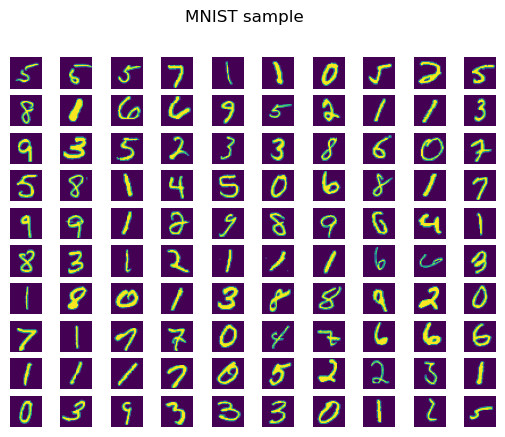

In [31]:
fig, axs = plt.subplots(10,10)
fig.suptitle(f'MNIST sample')
for ax, idx in zip(axs.flatten(),np.random.choice(len(data), 100)):
    ax.imshow(data[idx].reshape(28,28))
    ax.axis('off')

Perform PCA and estimate how many PCs are required to capture the most variance in the data. 

In [32]:
mnist_pca =  PCA()
mnist_pca.fit(data)

PCA()

Text(0.5, 0, 'Number of principal components')

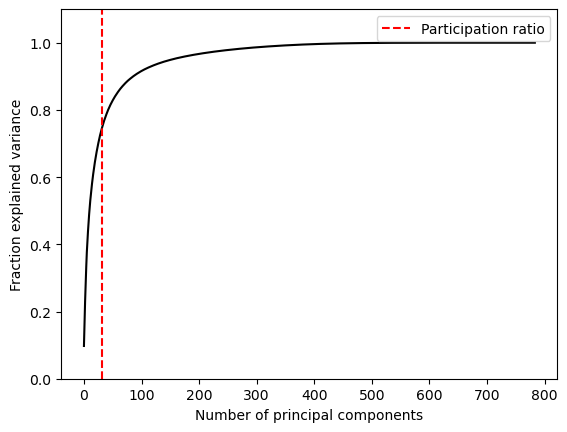

In [33]:
fig,ax = plt.subplots(1,1)
ax.plot(np.cumsum(mnist_pca.explained_variance_ratio_),color='k')
ax.vlines(analysis.get_participation_ratio(mnist_pca), ymin=0,ymax=1.1,linestyles='--',colors='r',label='Participation ratio')
ax.legend()
ax.set_ylim(0,1.1)
ax.set_ylabel('Fraction explained variance')
ax.set_xlabel('Number of principal components')

### As a first pass, reduce down to 50 dimensions; then cluster in this low dimensional space. 

In [34]:
lowd_mnist = PCA(n_components=50).fit_transform(data)
pca_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

#### Look how many data points were assigned a cluster as well as how many clusters were inferred. 

In [35]:
pca_clustered = (pca_labels >= 0)
print(f'Proportion of data points assigned to a cluster after PCA: {pca_clustered.sum()/len(lowd_mnist)}')
print(f'Number of found clusters: {len(np.unique(pca_labels[pca_labels >=0]))}')

Proportion of data points assigned to a cluster after PCA: 0.18664285714285714
Number of found clusters: 5


#### Visualize the principal components

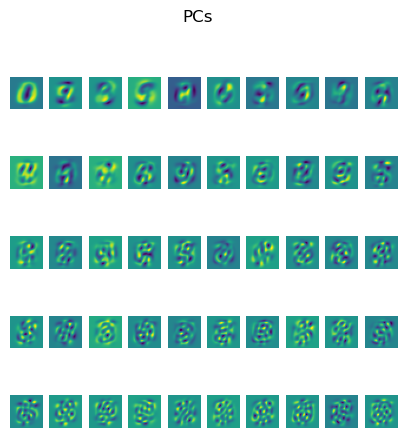

In [36]:
fig, axs = plt.subplots(5,10,figsize=(5,5))
fig.suptitle(f'PCs')
for ax, idx in zip(axs.flatten(),range(len(mnist_pca.components_))):
    ax.imshow(mnist_pca.components_[idx].reshape(28,28))
    ax.axis('off')

#### Category enrichment: Visualize examples within each found cluster

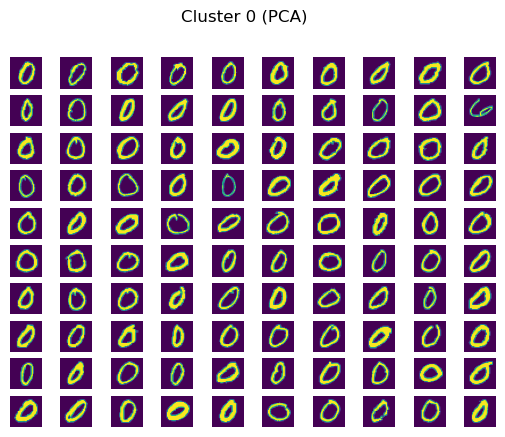

In [41]:
lab=0

pca_labeled_examples = []
for pred_label in np.unique(pca_labels[pca_labels >=0]):
    indices = (pca_labels == pred_label)
    pca_labeled_examples.append(data[indices])
    
fig, axs = plt.subplots(10,10)
fig.suptitle(f'Cluster {lab} (PCA)')
for ax, idx in zip(axs.flatten(),np.random.choice(len(pca_labeled_examples[lab]), 100)):
    ax.imshow(pca_labeled_examples[lab][idx].reshape(28,28))
    ax.axis('off')

#### Category enrichment: visualize components within a found cluster

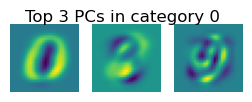

In [43]:
k=3
top_k_pcs = analysis.get_top_pcs(mnist_pca, pca_labeled_examples[lab],topk=3)
fig, axs = plt.subplots(1,3,figsize=(3,1))
fig.suptitle(f'Top {k} PCs in category {lab}')
for ax, idx in zip(axs.flatten(),top_k_pcs):
    ax.imshow(mnist_pca.components_[idx].reshape(28,28))
    ax.axis('off')

#### Are more clusters identifiable in UMAP space? 

In [65]:
# umap_embedding = umap.UMAP(n_neighbors=30, min_dist=0.1,n_components=2).fit_transform(data)
umap_embedding = umap.UMAP(n_neighbors=30, min_dist=0,n_components=2).fit_transform(data)

umap_labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(umap_embedding)

umap_clustered = (umap_labels >= 0)
print(f'Proportion of data points assigned to a cluster after UMAP: {umap_clustered.sum()/len(lowd_mnist)}')
print(f'Number of found clusters: {len(np.unique(umap_labels[umap_labels >=0]))}')

Proportion of data points assigned to a cluster after UMAP: 0.9892571428571428
Number of found clusters: 9


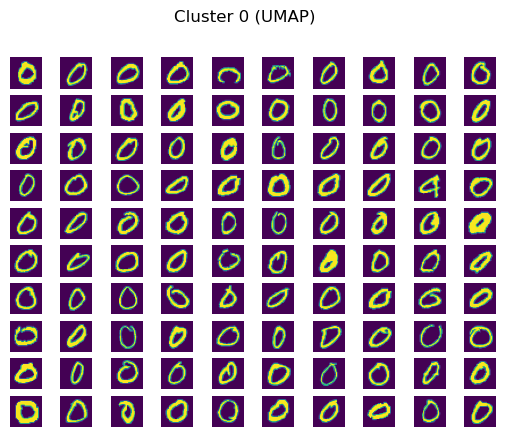

In [67]:
lab=0

umap_labeled_examples = []
for pred_label in np.unique(umap_labels[umap_labels >=0]):
    indices = (umap_labels == pred_label)
    umap_labeled_examples.append(data[indices])

fig, axs = plt.subplots(10,10)
fig.suptitle(f'Cluster {lab} (UMAP)')
for ax, idx in zip(axs.flatten(),np.random.choice(len(umap_labeled_examples[lab]), 100)):
    ax.imshow(umap_labeled_examples[lab][idx].reshape(28,28))
    ax.axis('off')

In [68]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(data)

/Users/andrew/mambaforge/envs/clustering/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


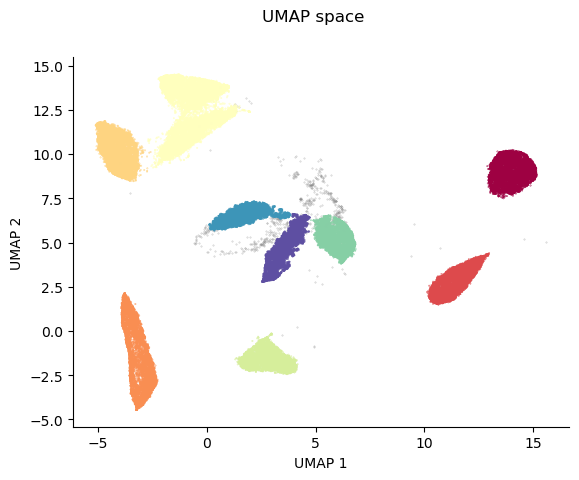

In [70]:
clustered = (umap_labels >= 0)
fig, ax = plt.subplots()
ax.scatter(standard_embedding[~umap_clustered, 0],
            standard_embedding[~umap_clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
ax.scatter(umap_embedding[umap_clustered, 0],
            umap_embedding[umap_clustered, 1],
            c=umap_labels[umap_clustered],
            s=0.1,
            cmap='Spectral')
fig.suptitle('UMAP space')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.spines[['top', 'right']].set_visible(False)

#### For comparison, let's look at how the PCA clusters align.

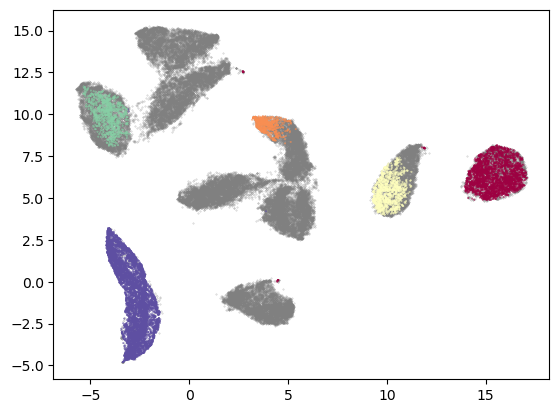

In [71]:
clustered = (pca_labels >= 0)
fig, ax = plt.subplots()
ax.scatter(standard_embedding[~pca_clustered, 0],
            standard_embedding[~pca_clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
ax.scatter(standard_embedding[pca_clustered, 0],
            standard_embedding[pca_clustered, 1],
            c=pca_labels[pca_clustered],
            s=0.1,
            cmap='Spectral')